# Network and Hierarchical Portfolios on the FTSE 100

This project studies portfolio construction methods that exploit correlation structure in FTSE 100 equities. Using daily data from 2015–2025, we compare classical Markowitz portfolios with network-based and hierarchical portfolios built from a data-driven correlation network. Portfolios are calibrated on 2015–2017 and evaluated out-of-sample over 2018–2025, focusing on risk–return trade-offs and robustness relative to the FTSE 100 benchmark.

## Executive Summary

- This project compares classical Markowitz portfolios, network-based portfolios (degeneracy, clique, eigenvector centrality), and hierarchical portfolios (cluster-equal, hierarchical 1/N, HRP, HERC) on FTSE 100 stocks.
- Portfolios are calibrated on 2015–2017 and held buy-and-hold over 2018–2025, using a static FTSE 100 universe and a data-driven correlation network.
- In-sample, the Markowitz max-Sharpe portfolio dominates in terms of return but is very unstable.
- Out-of-sample, network and hierarchical portfolios (especially HRP/HERC and hierarchical 1/N) deliver more stable risk–return profiles, with reasonable tracking error vs the FTSE 100.
- Performance is evaluated using annualized return, volatility, Sharpe ratio, max drawdown, and tracking error, and we discuss survivorship bias, transaction costs, and hyperparameter sensitivity as key limitations.

## Research Questions

1. **How do network-based and hierarchical portfolios perform relative to Markowitz and the FTSE 100 index, in- and out-of-sample?**
2. **Does using a data-driven correlation network and distance-of-distance clustering produce portfolios with better diversification and more stable OOS performance?**
3. **How closely do these portfolios track the FTSE 100 benchmark?**


## Setup and Configuration


In [198]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple, List, Dict
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from scipy.spatial.distance import squareform
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
np.random.seed(42)

In [199]:
IN_SAMPLE_START = '2015'
IN_SAMPLE_END = '2017'
OUT_SAMPLE_START = '2018'
OUT_SAMPLE_END = '2025'
MIN_DATA_AVAILABILITY = 0.90
NETWORK_THRESHOLD_QUANTILE = 0.80
CENTRALITY_THRESHOLD = 20
HIER_MAX_CLUSTERS = 4
HERC_MAX_DEPTH = 3
PERIODS_PER_YEAR = 252


### Model Configuration

The following table summarizes key hyperparameters and configuration choices used throughout the analysis:

| Parameter | Value | Description |
|-----------|-------|-------------|
| In-sample period | 2015–2017 | Training period for estimating covariances and constructing portfolios |
| Out-of-sample period | 2018–2025 | Evaluation period with frozen portfolio weights |
| Min data availability | 90% | Minimum fraction of stocks with valid prices required per trading day |
| Network threshold quantile | 0.80 | Percentile of correlation distribution used for network edge threshold |
| Centrality threshold | 20 | Minimum clique membership count for clique portfolio selection |
| Hierarchical clusters | 4 | Number of clusters for cluster-equal portfolio |
| HERC max depth | 3 | Maximum recursion depth for HERC portfolio (early stopping) |
| Periods per year | 252 | Trading days per year for annualization |


## 1. Data and Preprocessing

We work with daily closing prices for FTSE 100 constituents and the FTSE 100 index.

- **Universe:** Current or historical FTSE 100 members (we treat the set as static over the full sample; this introduces some survivorship bias).
- **Frequency:** Daily closes.
- **Sample:**
  - In-sample: 2015–2017 (used for estimating covariances and constructing portfolios),
  - Out-of-sample: 2018–2025 (used purely for performance evaluation).

**Preprocessing steps:**

1. Keep only stocks with at least some price data in the period.
2. For each day, require at least 90% of stocks to have a valid price; otherwise we drop that day. This ensures that the correlation and covariance estimates are not dominated by illiquid names or sparse data, and avoids artificial jumps in portfolio values that would come from days with very sparse data due to late listings, suspensions, or missing feeds.
3. Forward-fill missing prices to handle occasional gaps, then drop initial rows where data is still missing.
4. Compute daily percentage returns and the corresponding correlation matrix.

This preprocessing ensures robust correlation and covariance estimates for portfolio construction.


In [200]:
def preprocess_returns(data: pd.DataFrame, components: List[str], min_data_availability: float = 0.9) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    
    available_components = [c for c in components if c in data.columns]
    if len(available_components) == 0:
        raise ValueError("No components found in data.columns")
    
    data_subset = data[available_components]
    has_data = ~data_subset.isnull().all()
    components_with_data = [c for c in available_components if has_data[c]]
    
    if len(components_with_data) == 0:
        raise ValueError("No stocks have data in the specified period")
    
    non_null_count = data_subset[components_with_data].notna().sum(axis=1)
    total_stocks = len(components_with_data)
    available_pct = non_null_count / total_stocks
    
    valid_dates = available_pct >= min_data_availability
    data_filtered = data_subset[components_with_data].loc[valid_dates].copy()
    
    if len(data_filtered) == 0:
        raise ValueError(f"No dates have at least {min_data_availability*100:.0f}% data availability")
    
    data_filled = data_filtered.ffill()
    
    data_filled = data_filled.dropna()
    
    pctreturn = data_filled.pct_change().dropna()
    
    correlation = pctreturn.corr()
    
    return pctreturn, correlation, data_filled


### Performance Metrics

We evaluate portfolio performance using three annualized metrics computed from daily returns. We report all performance numbers at the daily frequency and then annualize them using 252 trading days per year.

**Annualized Mean Return:**
$$\mu_{\text{annual}} = 252 \times \bar{r}$$

where $\bar{r} = \frac{1}{T} \sum_{t=1}^T r_t$ is the sample mean of daily returns.

**Annualized Volatility:**
$$\sigma_{\text{annual}} = \sqrt{252} \times \hat{\sigma}$$

where $\hat{\sigma} = \sqrt{\frac{1}{T-1} \sum_{t=1}^T (r_t - \bar{r})^2}$ is the sample standard deviation of daily returns.

**Sharpe Ratio (assuming risk-free rate = 0):**
$$\text{Sharpe} = \frac{\mu_{\text{annual}}}{\sigma_{\text{annual}}} = \frac{\bar{r}}{\hat{\sigma}} \sqrt{252}$$

The Sharpe ratio measures risk-adjusted returns, with higher values indicating better risk-adjusted performance.


In [201]:
# Note: if some stocks are missing in OOS, weights are renormalized over remaining names.
def compute_weighted_portfolio(data: pd.DataFrame, weights: pd.Series, name: str = 'markowitz') -> pd.Series:
    common = [c for c in weights.index if c in data.columns]
    if not common:
        return pd.Series(0.0, index=data.index, name=name)
    w = weights[common].values
    if w.sum() != 0:
        w = w / w.sum()
    portfolio = (data[common] * w).sum(axis=1)
    portfolio.name = name
    return portfolio

def compute_equal_weighted_portfolio(data: pd.DataFrame, selected_stocks: List[str], name: str = 'portfolio') -> pd.Series:
    if not selected_stocks:
        return pd.Series(0, index=data.index, name=name)
    portfolio = data[selected_stocks].mean(axis=1)
    portfolio.name = name
    return portfolio

def compute_performance_metrics(returns: pd.Series, periods_per_year: int = 252) -> Dict[str, float]:
    if len(returns) == 0 or returns.std() == 0:
        return {'mean_return': 0.0, 'volatility': 0.0, 'sharpe_ratio': 0.0}
    mean_return = returns.mean() * periods_per_year
    volatility = returns.std() * np.sqrt(periods_per_year)
    sharpe_ratio = mean_return / volatility if volatility > 0 else 0.0
    return {'mean_return': mean_return, 'volatility': volatility, 'sharpe_ratio': sharpe_ratio}

def max_drawdown(series: pd.Series) -> float:
    
    if len(series) == 0:
        return 0.0
    cum = (1 + series).cumprod()
    peak = cum.cummax()
    dd = (cum - peak) / peak
    return dd.min()

def tracking_error(port_ret: pd.Series, bench_ret: pd.Series, periods_per_year: int = 252) -> float:
    
    common_idx = port_ret.index.intersection(bench_ret.index)
    if len(common_idx) == 0:
        return 0.0
    diff = port_ret[common_idx] - bench_ret[common_idx]
    return diff.std() * np.sqrt(periods_per_year)



In [202]:
def corr_distance_matrix(correlation: pd.DataFrame) -> np.ndarray:
    
    corr_values = correlation.values.copy()
    np.fill_diagonal(corr_values, 1.0)
    distance = np.sqrt(0.5 * (1 - corr_values))
    np.fill_diagonal(distance, 0.0)
    return distance

def corr_distance_of_distance_matrix(correlation: pd.DataFrame) -> np.ndarray:
    
    D = corr_distance_matrix(correlation)
    
    n = D.shape[0]
    Dtilde = np.zeros((n, n))
    
    for i in range(n):
        for j in range(i + 1, n):
            dist = np.linalg.norm(D[:, i] - D[:, j])
            Dtilde[i, j] = dist
            Dtilde[j, i] = dist
    
    np.fill_diagonal(Dtilde, 0.0)
    return Dtilde


In [203]:
def load_ftse100_data(csv_file: str = 'ftse_stock_prices.csv') -> Tuple[pd.DataFrame, List[str]]:
    
    df = pd.read_csv(csv_file)
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    
    components = [col for col in df.columns if col != 'FTSE100' and col != '.FTSE']
    if '.FTSE' in df.columns:
        df = df.rename(columns={'.FTSE': 'FTSE100'})
    
    metadata = df.copy()
    return metadata, components

metadata, components = load_ftse100_data('ftse_stock_prices.csv')
print(f"Loaded data for {len(components)} stocks")
print(f"Date range: {metadata.index.min()} to {metadata.index.max()}")
print(f"FTSE100 index included: {'FTSE100' in metadata.columns}")


Loaded data for 100 stocks
Date range: 2015-01-02 00:00:00 to 2025-12-05 00:00:00
FTSE100 index included: True


### Sample Split and Benchmark

We use the FTSE 100 index (**FTSE100** column) as our benchmark.

- **In-sample (2015–2017):** We estimate all covariance matrices and construct the network and hierarchical portfolios.
- **Out-of-sample (2018–2025):** All portfolio weights are frozen at their in-sample values and applied to new data. This corresponds to a buy-and-hold strategy from the perspective of the model (ignoring transaction costs and rebalancing).

**Note:** The FTSE index itself is rebalanced over time, so there is a small mismatch vs our static universe, but this is acceptable for this analysis.


In [204]:
in_sample_start = IN_SAMPLE_START
in_sample_end = IN_SAMPLE_END
out_sample_start = OUT_SAMPLE_START
out_sample_end = OUT_SAMPLE_END
centrality = CENTRALITY_THRESHOLD

in_sample_data = metadata[in_sample_start:in_sample_end].copy()
in_sample_returns, in_sample_correlation, in_sample_prices = preprocess_returns(
    in_sample_data, components, min_data_availability=MIN_DATA_AVAILABILITY
)

in_sample_data = in_sample_prices.copy()

in_sample_data['FTSE100'] = metadata.loc[in_sample_data.index, 'FTSE100'].ffill()

components = list(in_sample_returns.columns)
print(f"Using {len(components)} stocks with data in the in-sample period")


Using 95 stocks with data in the in-sample period


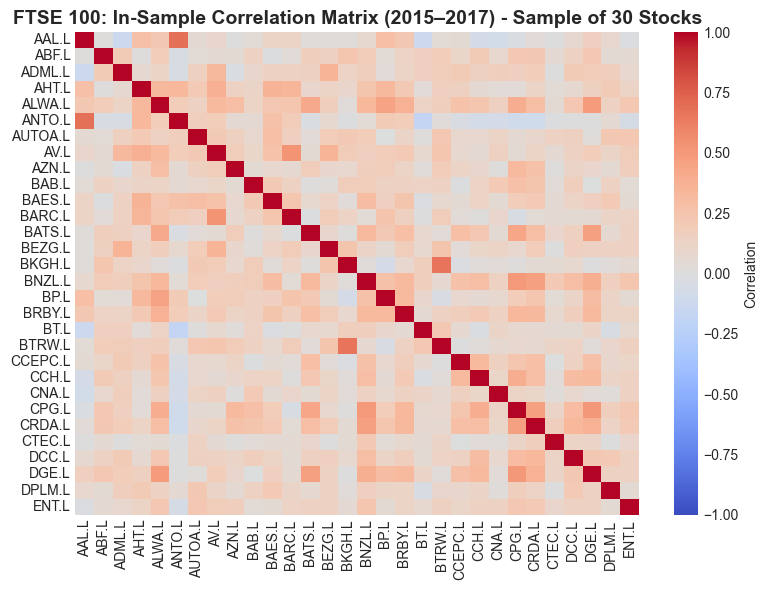

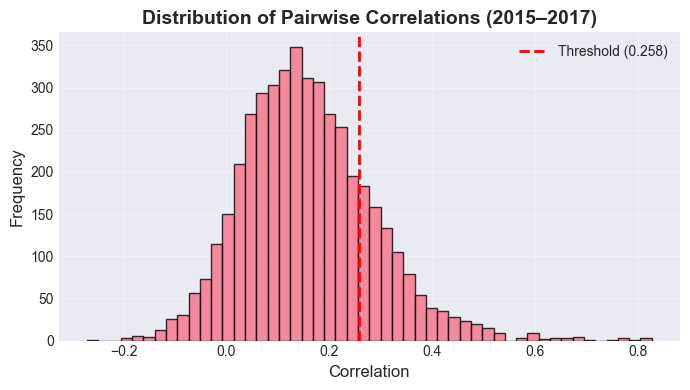

Correlation statistics:

  Mean correlation: 0.159
  Median correlation: 0.147
  Std correlation: 0.128
  Threshold q=0.80 corresponds to 0.258


In [205]:

fig, ax = plt.subplots(figsize=(8, 6))
sorted_stocks = sorted(in_sample_correlation.index)[:30]
corr_subset = in_sample_correlation.loc[sorted_stocks, sorted_stocks]
sns.heatmap(corr_subset, cmap='coolwarm', center=0, vmin=-1, vmax=1,
            xticklabels=True, yticklabels=True, ax=ax, 
            cbar_kws={'label': 'Correlation'})
ax.set_title('FTSE 100: In-Sample Correlation Matrix (2015–2017) - Sample of 30 Stocks', fontsize=14, fontweight='bold')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

corr_vals = in_sample_correlation.values
upper = corr_vals[np.triu_indices_from(corr_vals, k=1)]
upper = upper[~np.isnan(upper)]

threshold_quantile = NETWORK_THRESHOLD_QUANTILE
threshold = np.quantile(upper, threshold_quantile)

fig, ax = plt.subplots(figsize=(7, 4))
ax.hist(upper, bins=50, alpha=0.8, edgecolor='black')
ax.axvline(threshold, color='red', linestyle='--', linewidth=2, label=f'Threshold ({threshold:.3f})')
ax.set_xlabel('Correlation', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Distribution of Pairwise Correlations (2015–2017)', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Correlation statistics:\n")
print(f"  Mean correlation: {upper.mean():.3f}")
print(f"  Median correlation: {np.median(upper):.3f}")
print(f"  Std correlation: {upper.std():.3f}")
print(f"  Threshold q={threshold_quantile:.2f} corresponds to {threshold:.3f}")


**Interpretation**

- The in-sample correlation matrix shows several clusters that likely correspond to sectors such as banks, oil & gas, consumer staples, and utilities.
- Pairwise correlations are relatively low on average (mean ≈ 0.16, median ≈ 0.15), consistent with moderate co-movement within the FTSE 100. This is not unusual for UK stocks, which historically show lower correlations than US stocks due to sector diversity, currency effects, and market structure.
- A fixed threshold of 0.6 would correspond to a very high quantile (approximately 99.5th percentile) of this distribution and would almost empty the network, making network-based portfolios meaningless.
- Using the 80th percentile as threshold (corresponding to ρ ≈ 0.26) ensures that we keep only the strongest 20% of correlations, which yields a non-trivial and economically interpretable network for the portfolio constructions that follow.


## 2. Portfolio Construction

### 2.1 Markowitz Mean-Variance Optimization

The Markowitz (1952) framework forms the foundation of modern portfolio theory. We implement two variants:

#### 2.1.1 Minimum-Variance Portfolio

The global minimum-variance portfolio minimizes portfolio variance subject to the constraint that weights sum to one:

$$\min_{\mathbf{w}} \mathbf{w}^T \boldsymbol{\Sigma} \mathbf{w} \quad \text{subject to} \quad \mathbf{1}^T \mathbf{w} = 1$$

The solution is:

$$\mathbf{w}_{\text{minvar}} = \frac{\boldsymbol{\Sigma}^{-1} \mathbf{1}}{\mathbf{1}^T \boldsymbol{\Sigma}^{-1} \mathbf{1}}$$

where $\boldsymbol{\Sigma}$ is the covariance matrix of returns, and $\mathbf{1}$ is a vector of ones.

#### 2.1.2 Maximum-Sharpe Portfolio

The maximum-Sharpe portfolio maximizes the risk-adjusted return (Sharpe ratio), assuming a risk-free rate of zero:

$$\max_{\mathbf{w}} \frac{\boldsymbol{\mu}^T \mathbf{w}}{\sqrt{\mathbf{w}^T \boldsymbol{\Sigma} \mathbf{w}}} \quad \text{subject to} \quad \mathbf{1}^T \mathbf{w} = 1$$

The solution is:

$$\mathbf{w}_{\text{maxsharpe}} = \frac{\boldsymbol{\Sigma}^{-1} \boldsymbol{\mu}}{\mathbf{1}^T \boldsymbol{\Sigma}^{-1} \boldsymbol{\mu}}$$

where $\boldsymbol{\mu}$ is the vector of expected returns.

**Implementation Note:** In the implementation, we enforce long-only weights by truncating negative entries of the unconstrained solution at zero and re-normalizing. This is a heuristic projection onto the long-only simplex, not the exact constrained Markowitz solution (which would require solving a quadratic programming problem with inequality constraints).


In [206]:
def compute_markowitz_weights(returns: pd.DataFrame, allow_short: bool = False) -> Tuple[pd.Series, pd.Series]:
    returns = returns.dropna(axis=1, how='all')
    mu = returns.mean()
    Sigma = returns.cov()
    Sigma_inv = np.linalg.pinv(Sigma.values)
    ones = np.ones(len(mu))
    w_minvar = Sigma_inv @ ones
    denom_minvar = ones @ w_minvar
    if denom_minvar != 0:
        w_minvar = w_minvar / denom_minvar
    w_maxsharpe = Sigma_inv @ mu.values
    denom_maxsharpe = w_maxsharpe.sum()
    if denom_maxsharpe != 0:
        w_maxsharpe = w_maxsharpe / denom_maxsharpe
    if not allow_short:
        w_minvar = np.maximum(w_minvar, 0.0)
        if w_minvar.sum() > 0:
            w_minvar = w_minvar / w_minvar.sum()
        w_maxsharpe = np.maximum(w_maxsharpe, 0.0)
        if w_maxsharpe.sum() > 0:
            w_maxsharpe = w_maxsharpe / w_maxsharpe.sum()
    w_minvar = pd.Series(w_minvar, index=mu.index, name='markowitz_minvar')
    w_maxsharpe = pd.Series(w_maxsharpe, index=mu.index, name='markowitz_maxsharpe')
    return w_minvar, w_maxsharpe

minvar_w, maxsharpe_w = compute_markowitz_weights(in_sample_returns, allow_short=False)
in_sample_data['markowitz_minvar'] = compute_weighted_portfolio(in_sample_data, minvar_w, 'markowitz_minvar')
in_sample_data['markowitz_maxsharpe'] = compute_weighted_portfolio(in_sample_data, maxsharpe_w, 'markowitz_maxsharpe')

print("Minimum-Variance Portfolio:")
print("=" * 70)
print(f"Number of stocks: {(minvar_w > 0.001).sum()}")
print("\nTop 3 and Bottom 3 holdings:")
top_minvar_all = minvar_w[minvar_w > 0.001].sort_values(ascending=False)
top_minvar = top_minvar_all.head(3)
bottom_minvar = top_minvar_all.tail(3)
for stock, weight in top_minvar.items():
    print(f"  {stock:<20} {weight*100:>6.2f}%")
print("  ...")
for stock, weight in bottom_minvar.items():
    print(f"  {stock:<20} {weight*100:>6.2f}%")
print("\n" + "=" * 70)

print("\nMaximum-Sharpe Portfolio:")
print("=" * 70)
print(f"Number of stocks: {(maxsharpe_w > 0.001).sum()}")
print("\nTop 3 and Bottom 3 holdings:")
top_maxsharpe_all = maxsharpe_w[maxsharpe_w > 0.001].sort_values(ascending=False)
top_maxsharpe = top_maxsharpe_all.head(3)
bottom_maxsharpe = top_maxsharpe_all.tail(3)
for stock, weight in top_maxsharpe.items():
    print(f"  {stock:<20} {weight*100:>6.2f}%")
print("  ...")
for stock, weight in bottom_maxsharpe.items():
    print(f"  {stock:<20} {weight*100:>6.2f}%")
print("=" * 70)


Minimum-Variance Portfolio:
Number of stocks: 52

Top 3 and Bottom 3 holdings:
  ALWA.L                 7.20%
  SSE.L                  7.07%
  FCIT.L                 5.17%
  ...
  BTRW.L                 0.29%
  BAB.L                  0.28%
  HLMA.L                 0.19%


Maximum-Sharpe Portfolio:
Number of stocks: 42

Top 3 and Bottom 3 holdings:
  REL.L                  6.98%
  ALWA.L                 6.64%
  SGRO.L                 6.51%
  ...
  RTO.L                  0.28%
  KGF.L                  0.24%
  HSBA.L                 0.20%


**Network Threshold Choice.**

For the FTSE 100, pairwise correlations are relatively low (mean ≈ 0.16, median ≈ 0.15). A fixed threshold of 0.6 would correspond to about the 99.5th percentile and produce an almost empty network. Instead, we use a **data-driven threshold** equal to the 80th percentile of the in-sample correlation distribution. Edges connect the top 20% most strongly correlated pairs, which yields a richer network and makes the degeneracy and clique portfolios economically meaningful.


### 2.2 Network Portfolios

#### 2.2.1 Degeneracy Ordering Portfolio

This method constructs an **independent vertex set** in the correlation network. An independent set is a subset of nodes where no two nodes are connected by an edge, ensuring low pairwise correlations.

**Algorithm:**
1. Compute k-core numbers for all nodes using k-core decomposition
2. Sort nodes by core number (ascending)
3. Greedily select nodes such that no selected node is adjacent to any previously selected node

**Result:** A diversified portfolio where selected stocks have minimal direct correlations, as they are not connected in the thresholded correlation network.

In [207]:
def create_graph(components: List[str], correlation: pd.DataFrame, 
                 threshold: float) -> Tuple[nx.Graph, Dict]:
    
    graph = nx.Graph()
    valid_components = [c for c in components if c in correlation.index and c in correlation.columns]
    graph.add_nodes_from(valid_components)
    
    for i in range(len(valid_components)):
        for j in range(i + 1, len(valid_components)):
            stock_i = valid_components[i]
            stock_j = valid_components[j]
            if stock_i in correlation.index and stock_j in correlation.columns:
                corr_val = correlation.loc[stock_i, stock_j]
                if corr_val > threshold:
                    graph.add_edge(stock_i, stock_j, weight=corr_val)
    
    layout = nx.spring_layout(graph, seed=42) if len(graph.nodes) > 0 else {}
    return graph, layout

def create_full_correlation_graph(components: List[str], correlation: pd.DataFrame) -> nx.Graph:
    
    graph = nx.Graph()
    valid_components = [c for c in components if c in correlation.index and c in correlation.columns]
    graph.add_nodes_from(valid_components)
    
    for i in range(len(valid_components)):
        for j in range(i + 1, len(valid_components)):
            stock_i = valid_components[i]
            stock_j = valid_components[j]
            if stock_i in correlation.index and stock_j in correlation.columns:
                corr_val = correlation.loc[stock_i, stock_j]
                weight = max(corr_val, 0.0)
                if weight > 0:
                    graph.add_edge(stock_i, stock_j, weight=weight)
    return graph


In [208]:
def degeneracy_ordering(graph: nx.Graph, components: List[str]) -> Tuple[List[str], List[str]]:
    degeneracy = dict(sorted(nx.core_number(graph).items(), key=lambda x: x[1]))
    independence = []
    for i in degeneracy:
        if not set(graph.neighbors(i)).intersection(set(independence)):
            independence.append(i)
    leftout = [i for i in components if i not in graph.nodes]
    return independence, leftout


In [209]:
in_sample_graph, in_sample_layout = create_graph(components, in_sample_correlation, threshold)
in_sample_full_graph = create_full_correlation_graph(components, in_sample_correlation)

### Network Diagnostics

The data-driven threshold ensures a meaningful network structure for the degeneracy and clique portfolios. Below we report key network statistics: number of nodes and edges, edge density (fraction of possible edges that exist), and average node degree. These metrics confirm that the 80th percentile threshold produces a non-trivial network topology, unlike a fixed threshold of 0.6 which would result in an almost empty graph for FTSE 100 data.


In [210]:
deg = dict(in_sample_graph.degree())
num_nodes = in_sample_graph.number_of_nodes()
num_edges = in_sample_graph.number_of_edges()
avg_degree = np.mean(list(deg.values())) if len(deg) > 0 else 0.0
edge_density = 2 * num_edges / (num_nodes * (num_nodes - 1)) if num_nodes > 1 else 0.0

print(f"Network stats (threshold q={threshold_quantile:.2f}, rho={threshold:.3f}):")
print(f"  Nodes: {num_nodes}")
print(f"  Edges: {num_edges}")
print(f"  Edge density: {edge_density:.4f}")
print(f"  Avg degree: {avg_degree:.2f}")


Network stats (threshold q=0.80, rho=0.258):
  Nodes: 95
  Edges: 893
  Edge density: 0.2000
  Avg degree: 18.80


In [211]:
independence, leftout = degeneracy_ordering(in_sample_graph, components)
in_sample_data['degeneracy'] = compute_equal_weighted_portfolio(in_sample_data, leftout + independence, 'degeneracy')

selected_stocks = leftout + independence
print("Degeneracy Portfolio:")
print("=" * 70)
print(f"Total stocks selected: {len(selected_stocks)}")
print(f"  - Stocks not in network (leftout): {len(leftout)}")
print(f"  - Independent set from network: {len(independence)}")
print("\nTop 3 and Bottom 3 selected stocks:")
if len(selected_stocks) > 6:
    top_three = selected_stocks[:3]
    bottom_three = selected_stocks[-3:]
    for i, stock in enumerate(top_three, 1):
        print(f"  {i:2d}. {stock}")
    print("  ...")
    for idx, stock in enumerate(bottom_three):
        i = len(selected_stocks) - 2 + idx
        print(f"  {i:2d}. {stock}")
else:
    for i, stock in enumerate(selected_stocks, 1):
        print(f"  {i:2d}. {stock}")
print("=" * 70)

Degeneracy Portfolio:
Total stocks selected: 28
  - Stocks not in network (leftout): 0
  - Independent set from network: 28

Top 3 and Bottom 3 selected stocks:
   1. PSON.L
   2. CTEC.L
   3. GAW.L
  ...
  26. BP.L
  27. HLMA.L
  28. MRON.L


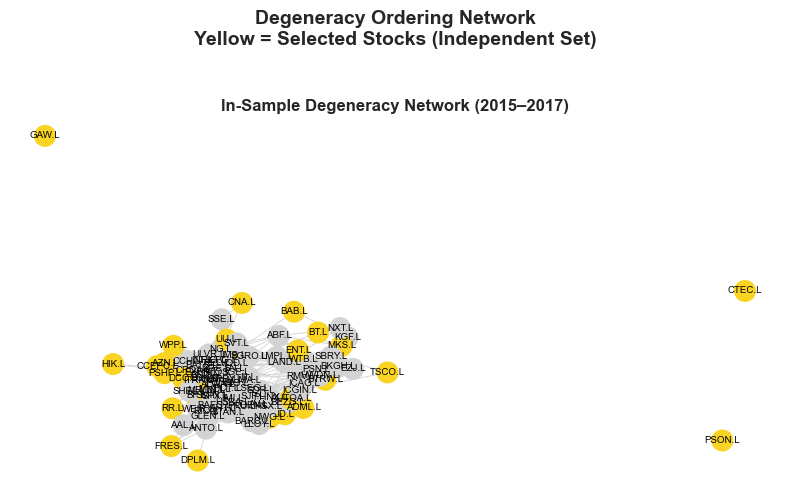

In [212]:
def draw_degeneracy_network(ax, graph, layout, selected, title):
    if len(graph.nodes) == 0:
        ax.text(0.5, 0.5, 'Empty Graph', ha='center', va='center',
                transform=ax.transAxes)
        ax.set_title(title, fontsize=12, fontweight='bold')
        ax.axis('off')
        return
    
    node_colors = ['#F9D423' if n in selected else '#D3D3D3' for n in graph.nodes]
    nx.draw(
        graph,
        pos=layout,
        node_color=node_colors,
        node_size=220,
        with_labels=True,
        font_size=7,
        edge_color='lightgray',
        width=0.6,
        ax=ax
    )
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.axis('off')

fig, ax = plt.subplots(figsize=(8, 5))
fig.suptitle('Degeneracy Ordering Network\nYellow = Selected Stocks (Independent Set)',
             fontsize=14, fontweight='bold', y=0.98)

draw_degeneracy_network(
    ax,
    in_sample_graph,
    in_sample_layout,
    independence,
    'In-Sample Degeneracy Network (2015–2017)'
)

plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.show()

**What the degeneracy network shows**

- The thresholded network has a specific number of nodes and edges, with edge density and average degree as shown in the printed network statistics above.
- The degeneracy portfolio selects an independent set of nodes plus stocks that are not in the network at all, so by construction there are no edges between selected nodes in the thresholded graph.
- Economically, this means the degeneracy portfolio intentionally avoids direct high correlations, leading to a very "spread-out" set of stocks in the network.
- This is a strong diversification heuristic and provides a useful contrast to clique and eigenvector-central portfolios, which tilt toward more central / connected names.


#### 2.2.2 Clique Centrality Portfolio

This method identifies "hub" stocks that belong to many maximal cliques (complete subgraphs). A maximal clique is a set of nodes that form a complete subgraph and cannot be extended by adding another node.

**Algorithm:**
1. Find all maximal cliques in the correlation network
2. Count clique membership: $c_i = |\{C : i \in C, C \text{ is a maximal clique}\}|$
3. Select stocks with $c_i > \theta$ (threshold $\theta$)

**Result:** A portfolio concentrated on systemically important stocks that are central to multiple highly correlated groups.

In [213]:
def clique_centrality(graph: nx.Graph, centrality: int = 10, top_k: int = 10) -> List[str]:
    cliques = list(nx.find_cliques(graph))
    if not cliques:
        return []
    
    flat_nodes = [j for i in cliques for j in i]
    counts = {}
    for node in set(flat_nodes):
        counts[node] = flat_nodes.count(node)
    
    selected = [node for node, c in counts.items() if c > centrality]
    
    if not selected:
        selected = [node for node, _ in sorted(counts.items(),
                                               key=lambda x: x[1],
                                               reverse=True)[:top_k]]
    return selected

In [214]:
clique_selected = clique_centrality(in_sample_graph, centrality)
in_sample_data['clique'] = compute_equal_weighted_portfolio(in_sample_data, clique_selected, 'clique')

print("Clique Centrality Portfolio:")
print("=" * 70)
print(f"Total stocks selected: {len(clique_selected)}")
print("\nTop 3 and Bottom 3 selected stocks (hub stocks in multiple cliques):")
if len(clique_selected) > 6:
    top_three = clique_selected[:3]
    bottom_three = clique_selected[-3:]
    for i, stock in enumerate(top_three, 1):
        print(f"  {i:2d}. {stock}")
    print("  ...")
    for idx, stock in enumerate(bottom_three):
        i = len(clique_selected) - 2 + idx
        print(f"  {i:2d}. {stock}")
else:
    for i, stock in enumerate(clique_selected, 1):
        print(f"  {i:2d}. {stock}")
print("=" * 70)

Clique Centrality Portfolio:
Total stocks selected: 38

Top 3 and Bottom 3 selected stocks (hub stocks in multiple cliques):
   1. MNDI.L
   2. CPG.L
   3. BNZL.L
  ...
  36. AV.L
  37. SMT.L
  38. IHG.L


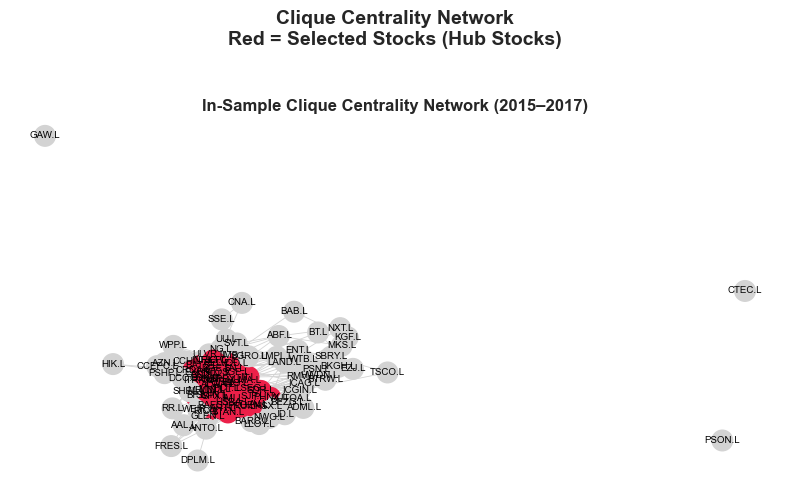

In [215]:

def draw_clique_network(ax, graph, layout, selected, title):
    if len(graph.nodes) == 0:
        ax.text(0.5, 0.5, 'Empty Graph', ha='center', va='center',
                transform=ax.transAxes)
        ax.set_title(title, fontsize=12, fontweight='bold')
        ax.axis('off')
        return
    
    node_colors = ['#EC2049' if n in selected else '#D3D3D3' for n in graph.nodes]
    nx.draw(
        graph,
        pos=layout,
        node_color=node_colors,
        node_size=220,
        with_labels=True,
        font_size=7,
        edge_color='lightgray',
        width=0.6,
        ax=ax
    )
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.axis('off')

fig, ax = plt.subplots(figsize=(8, 5))
fig.suptitle('Clique Centrality Network\nRed = Selected Stocks (Hub Stocks)',
             fontsize=14, fontweight='bold', y=0.98)

draw_clique_network(
    ax,
    in_sample_graph,
    in_sample_layout,
    clique_selected,
    'In-Sample Clique Centrality Network (2015–2017)'
)

plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.show()

**Interpretation**

- Stocks selected by the clique centrality rule belong to many maximal cliques, i.e. they sit in the middle of tightly knit, highly correlated groups.
- These "hub" stocks capture co-movement across several clusters, which can be good for capturing systematic factors.
- Comparing degeneracy vs clique portfolios later will show the performance trade-off between "anti-correlation" diversification (degeneracy) and "central hub" exposure (clique).


#### 2.2.3 Eigenvector Centrality Portfolios

Eigenvector centrality measures a node's importance based on the importance of its neighbors. For a graph with adjacency matrix $\mathbf{A}$ and weight matrix $\mathbf{W}$, the eigenvector centrality $\mathbf{s}$ satisfies:

$$\lambda \mathbf{s} = \mathbf{W} \mathbf{s}$$

where $\lambda$ is the largest eigenvalue.

**Central Portfolio:**
$$\mathbf{w}_{\text{central}} = \frac{\mathbf{s}}{\mathbf{1}^T \mathbf{s}}$$

**Inverse Central Portfolio:**
$$\mathbf{w}_{\text{inverse}} = \frac{\mathbf{s}^{-1}}{\mathbf{1}^T \mathbf{s}^{-1}}$$

where $\mathbf{s}^{-1}$ denotes element-wise inverse.

**Result:** The central portfolio tilts toward systemically important stocks, while the inverse portfolio favors peripheral stocks.

**Note:** Portfolio weights are computed using the full positive-correlation graph (all $\rho > 0$), while the network visualization uses the thresholded graph (80th percentile) for consistency with degeneracy and clique visualizations. Both approaches are valid; the full graph captures all positive correlations for portfolio construction, while the thresholded graph provides a clearer visual representation of the strongest relationships.

In [216]:
def eigenvector_centrality_weights(graph: nx.Graph, components: List[str], inverse: bool = False) -> pd.Series:
    if len(graph.nodes) == 0:
        return pd.Series(0.0, index=components, name='eigen_centrality')
    ec_dict = nx.eigenvector_centrality_numpy(graph, weight='weight')
    ec = pd.Series(ec_dict, name='eigen_centrality')
    ec = ec.reindex(components).fillna(0.0)
    if inverse:
        ec = 1.0 / (ec.replace(0, np.nan))
        ec = ec.fillna(0.0)
    if ec.sum() != 0:
        ec = ec / ec.sum()
    return ec

In [217]:
eigen_w_central = eigenvector_centrality_weights(in_sample_full_graph, components, inverse=False)
in_sample_data['eigen_central'] = compute_weighted_portfolio(in_sample_data, eigen_w_central, 'eigen_central')

print("Eigenvector Centrality Portfolio:")
print("=" * 70)
print(f"Number of stocks with non-zero weight: {(eigen_w_central > 0.001).sum()}")
print("\nTop 3 and Bottom 3 holdings (by eigenvector centrality):")
top_eigen_all = eigen_w_central[eigen_w_central > 0.001].sort_values(ascending=False)
top_eigen = top_eigen_all.head(3)
bottom_eigen = top_eigen_all.tail(3)
for stock, weight in top_eigen.items():
    print(f"  {stock:<20} {weight*100:>6.2f}%")
print("  ...")
for stock, weight in bottom_eigen.items():
    print(f"  {stock:<20} {weight*100:>6.2f}%")
print("=" * 70)


Eigenvector Centrality Portfolio:
Number of stocks with non-zero weight: 95

Top 3 and Bottom 3 holdings (by eigenvector centrality):
  ALWA.L                 1.81%
  FCIT.L                 1.80%
  SMT.L                  1.78%
  ...
  CTEC.L                 0.46%
  PSON.L                 0.34%
  GAW.L                  0.24%


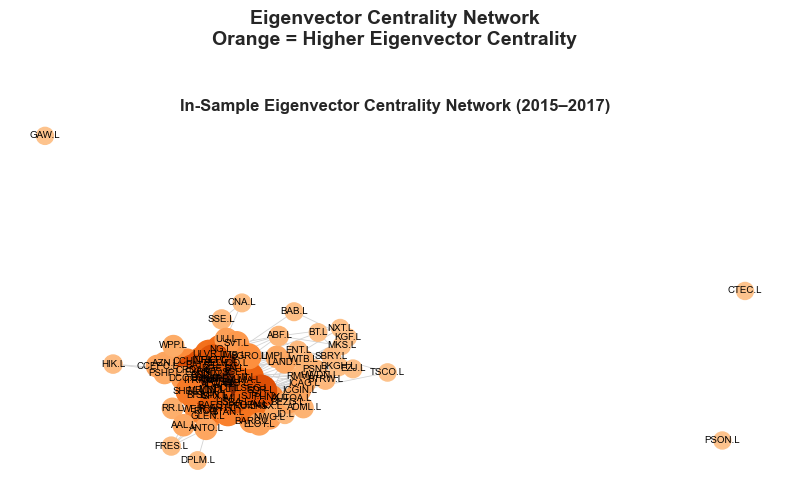

In [218]:
def compute_eigen_centrality_safe(graph):
    
    if len(graph.nodes) == 0:
        return {}
    return nx.eigenvector_centrality(graph, weight='weight', max_iter=1000)

in_ec = compute_eigen_centrality_safe(in_sample_graph)

def draw_eigen_network(ax, graph, layout, ec_dict, title):
    if len(graph.nodes) == 0:
        ax.text(0.5, 0.5, 'Empty Graph', ha='center', va='center',
                transform=ax.transAxes)
        ax.set_title(title, fontsize=12, fontweight='bold')
        ax.axis('off')
        return
    
    # Centrality values
    vals = np.array([ec_dict.get(n, 0.0) for n in graph.nodes])
    if vals.max() > 0:
        norm = vals / vals.max()
    else:
        norm = vals
    
    # Orange gradient + size scaling
    cmap = plt.cm.Oranges
    node_colors = [cmap(0.3 + 0.7 * v) for v in norm]  # avoid too pale
    node_sizes = 150 + 600 * norm                      # base + scaled
    
    nx.draw(
        graph,
        pos=layout,
        node_color=node_colors,
        node_size=node_sizes,
        with_labels=True,
        font_size=7,
        edge_color='lightgray',
        width=0.6,
        ax=ax
    )
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.axis('off')

fig, ax = plt.subplots(figsize=(8, 5))
fig.suptitle('Eigenvector Centrality Network\nOrange = Higher Eigenvector Centrality',
             fontsize=14, fontweight='bold', y=0.98)

draw_eigen_network(
    ax,
    in_sample_graph,
    in_sample_layout,
    in_ec,
    'In-Sample Eigenvector Centrality Network (2015–2017)'
)

plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.show()

**Interpretation**

- Node size and color intensity reflect eigenvector centrality: nodes that are connected to other important nodes become large and dark orange.
- The eigenvector centrality portfolio overweights these nodes in the **full** positive-correlation graph, not just the thresholded one, which effectively concentrates exposure in systemically important FTSE 100 names.
- This portfolio should behave somewhat like a "network beta" trade: high exposure to the main market mode, lower idiosyncratic diversification.


### 2.3 Hierarchical Methods

For HRP, HERC, and hierarchical 1/N, we follow the hierarchical portfolio construction in López de Prado (2016) and Palomar (2025), using a distance-of-distance matrix for clustering and waterfall (50–50) splits for hierarchical 1/N.

**Summary of Hierarchical Methods:**

| Method | Distance Metric | Linkage | Allocation Rule |
|--------|----------------|---------|-----------------|
| Cluster Equal | Correlation distance | Average | Equal across clusters & members |
| Hierarchical 1/N | Distance-of-distance | Ward | 50/50 splits at each branch |
| HRP | Distance-of-distance | Single | Inverse-variance cluster splits |
| HERC | Distance-of-distance | Ward | Equal risk contribution splits |


**Distance Metric Choice:** We use a distance-of-distance matrix (second-order distances) for HRP, HERC, and hierarchical 1/N, rather than the simple correlation distance used in the original López de Prado (2016) HRP specification. The distance-of-distance metric amplifies second-order relationships between assets and tends to produce cleaner hierarchical blocks in the dendrogram. This approach is inspired by recent extensions (e.g., Palomar, 2025) and helps capture more nuanced similarity structures in large universes.


#### 2.3.1 Cluster Equal-Weight Portfolio

This method uses hierarchical clustering to identify groups of correlated assets, then applies equal weighting at two levels.

**Distance Metric:**
$$d_{ij} = \sqrt{\tfrac{1}{2}(1 - \rho_{ij})}$$

where $\rho_{ij}$ is the correlation between assets $i$ and $j$. We cut the dendrogram into 4 clusters using `maxclust=4`.

**Weight Allocation:**
For asset $i$ in cluster $c$ with $n_c$ members and $K$ total clusters:

$$w_i = \frac{1}{K \cdot n_c}$$

**Result:** Ensures representation across different correlation clusters while maintaining equal weights within each cluster.

In [219]:
def hierarchical_clusters_from_corr(correlation: pd.DataFrame, method: str = 'average', max_clusters: int = 4) -> Tuple[pd.Series, np.ndarray]:
    
    corr = correlation.copy()
    corr = corr.fillna(0.0)
    np.fill_diagonal(corr.values, 1.0)
    corr = corr.clip(-1.0, 1.0)
    dist = np.sqrt(0.5 * (1 - corr.values))
    dist = np.nan_to_num(dist, nan=1.0, posinf=1.0, neginf=1.0)
    condensed = squareform(dist, checks=False)
    condensed = np.nan_to_num(condensed, nan=1.0, posinf=1.0, neginf=1.0)
    Z = linkage(condensed, method=method)
    labels = fcluster(Z, max_clusters, criterion='maxclust')
    labels = pd.Series(labels, index=correlation.index, name='cluster')
    return labels, Z

def cluster_equal_weights(labels: pd.Series) -> pd.Series:
    weights = pd.Series(0.0, index=labels.index)
    clusters = labels.unique()
    n_clusters = len(clusters)
    for c in clusters:
        members = labels.index[labels == c]
        if len(members) == 0:
            continue
        weights.loc[members] = 1.0 / (n_clusters * len(members))
    weights.name = 'cluster_equal'
    return weights

In [220]:
cluster_labels, Z = hierarchical_clusters_from_corr(
    in_sample_correlation, method='average', max_clusters=HIER_MAX_CLUSTERS
)
cluster_w = cluster_equal_weights(cluster_labels)
in_sample_data['cluster_equal'] = compute_weighted_portfolio(in_sample_data, cluster_w, 'cluster_equal')

print("Hierarchical Clustering Portfolio:")
print("=" * 70)
print(f"Number of clusters: {cluster_labels.nunique()}")
print("\nCluster composition (First 2 and Last 2 clusters):")
sorted_clusters = sorted(cluster_labels.unique())
first_two = sorted_clusters[:2]
last_two = sorted_clusters[-2:] if len(sorted_clusters) > 2 else []
for cluster_id in first_two:
    members = cluster_labels[cluster_labels == cluster_id].index.tolist()
    print(f"\nCluster {cluster_id} ({len(members)} stocks)")
if last_two and last_two != first_two:
    print("\n...")
    for cluster_id in last_two:
        members = cluster_labels[cluster_labels == cluster_id].index.tolist()
        print(f"\nCluster {cluster_id} ({len(members)} stocks)")
print("=" * 70)

Hierarchical Clustering Portfolio:
Number of clusters: 4

Cluster composition (First 2 and Last 2 clusters):

Cluster 1 (2 stocks)

Cluster 2 (91 stocks)

...

Cluster 3 (1 stocks)

Cluster 4 (1 stocks)


#### 2.3.2 Hierarchical Risk Parity (HRP) Portfolio

The Hierarchical Risk Parity (HRP) portfolio (López de Prado, 2016) uses the same correlation tree as the cluster-equal portfolio, but allocates more weight to low-variance clusters instead of using simple equal weights. HRP is a graph-based portfolio that uses hierarchical clustering to allocate weights based on the correlation structure, employing the inverse-variance portfolio (IVarP) for weight allocation.

**Algorithm:**
1. **Distance Matrix**: In López de Prado (2016), the correlation matrix is converted to a simple distance matrix {ij} = \sqrt{\tfrac{1}{2}(1 - \rho_{ij})}$. In our implementation, we keep the HRP *allocation logic* but replace this by a **distance-of-distance** matrix (as described in Section 3.3), in line with Palomar-style extensions. This tends to produce cleaner blocks in the dendrogram.
2. **Hierarchical Clustering**: Perform hierarchical clustering using single linkage
3. **Quasi-Diagonalization**: Reorder the covariance matrix based on clustering structure
4. **Recursive Bisection**: 
   - Start with all assets
   - Split into two groups based on dendrogram ordering
   - Compute variance of each group using inverse-variance portfolio
   - Allocate weights inversely proportional to variance: $\alpha = \frac{\sigma_2^2}{\sigma_1^2 + \sigma_2^2}$
   - Repeat until each group contains one asset

**Key Difference from Hierarchical 1/N**: HRP uses inverse-variance weighting instead of equal weighting, making it more sensitive to risk differences between assets.

**Result:** A diversified portfolio that accounts for both correlation structure and individual asset variances, providing a more robust alternative to traditional mean-variance optimization.


In [221]:
def hrp_weights(covariance: pd.DataFrame, linkage_method: str = 'single') -> pd.Series:
    
    std_dev = np.sqrt(np.diag(covariance.values))
    correlation = covariance.values / np.outer(std_dev, std_dev)
    correlation_df = pd.DataFrame(correlation, index=covariance.index, columns=covariance.index)
    
    distance_matrix = corr_distance_of_distance_matrix(correlation_df)
    
    condensed_dist = squareform(distance_matrix, checks=False)
    linkage_matrix = linkage(condensed_dist, method=linkage_method)
    
    n_items = len(covariance.index)
    sorted_index = quasi_diagonalize(linkage_matrix, n_items)
    
    sorted_items = [covariance.index[i] for i in sorted_index]
    cov_sorted = covariance.loc[sorted_items, sorted_items]
    
    weights = pd.Series(1.0, index=sorted_items)
    
    groups = [list(range(n_items))]
    
    while any(len(g) > 1 for g in groups):
        new_groups = []
        
        for group in groups:
            if len(group) <= 1:
                new_groups.append(group)
                continue
            
            mid = len(group) // 2
            group_1 = group[:mid]
            group_2 = group[mid:]
            
            items_1 = [sorted_items[i] for i in group_1]
            items_2 = [sorted_items[i] for i in group_2]
            
            cov_1 = cov_sorted.loc[items_1, items_1].values
            cov_2 = cov_sorted.loc[items_2, items_2].values
            
            var_1 = compute_cluster_variance(cov_1)
            var_2 = compute_cluster_variance(cov_2)
            
            alpha = var_2 / (var_1 + var_2) if (var_1 + var_2) > 0 else 0.5
            
            for i in group_1:
                weights.iloc[i] *= alpha
            for i in group_2:
                weights.iloc[i] *= (1 - alpha)
            
            new_groups.append(group_1)
            new_groups.append(group_2)
        
        groups = new_groups
    
    weights = weights / weights.sum()
    weights.name = 'hrp'
    
    weights = weights.reindex(covariance.index).fillna(0.0)
    
    return weights


In [222]:
def get_leaves(cluster_id: int, linkage_matrix: np.ndarray, n_items: int) -> List[int]:
    
    if cluster_id < n_items:
        return [cluster_id]
    else:
        cluster_idx = cluster_id - n_items
        left_child = int(linkage_matrix[cluster_idx, 0])
        right_child = int(linkage_matrix[cluster_idx, 1])
        return get_leaves(left_child, linkage_matrix, n_items) + get_leaves(right_child, linkage_matrix, n_items)

def hierarchical_one_over_n_weights(
    correlation: pd.DataFrame,
    linkage_method: str = "ward",
    use_distance_of_distance: bool = False,
) -> pd.Series:
    
    if use_distance_of_distance:
        distance_matrix = corr_distance_of_distance_matrix(correlation)
    else:
        distance_matrix = corr_distance_matrix(correlation)
    
    condensed_dist = squareform(distance_matrix, checks=False)
    linkage_matrix = linkage(condensed_dist, method=linkage_method)
    
    n_items = len(correlation.index)
    root_cluster_id = 2 * n_items - 2
    
    weights_dict = {i: 0.0 for i in range(n_items)}
    
    def assign_weight_recursive(cluster_id: int, weight: float):
        
        if cluster_id < n_items:
            # Leaf node: assign weight directly
            weights_dict[cluster_id] = weight
        else:
            # Internal cluster: split weight equally between children
            cluster_idx = cluster_id - n_items
            left_child = int(linkage_matrix[cluster_idx, 0])
            right_child = int(linkage_matrix[cluster_idx, 1])
            assign_weight_recursive(left_child, weight / 2.0)
            assign_weight_recursive(right_child, weight / 2.0)
    
    # Start from root with weight 1.0
    assign_weight_recursive(root_cluster_id, 1.0)
    
    # Convert to pd.Series
    weights = pd.Series([weights_dict[i] for i in range(n_items)], index=correlation.index)
    
    # Normalize (should already sum to 1, but ensure it)
    weights = weights / weights.sum()
    weights.name = 'hier_1N'
    
    return weights


In [223]:
h1n_weights = hierarchical_one_over_n_weights(
    in_sample_correlation,
    linkage_method="ward",
    use_distance_of_distance=True
)
in_sample_data["hier_1N"] = compute_weighted_portfolio(in_sample_data, h1n_weights, "hier_1N")

print("Hierarchical 1/N Portfolio (Waterfall):")
print("=" * 70)
print(f"Number of stocks with non-zero weight: {(h1n_weights > 0.001).sum()}")
print("\nTop 3 and Bottom 3 holdings:")
top_h1n_all = h1n_weights[h1n_weights > 0.001].sort_values(ascending=False)
top_h1n = top_h1n_all.head(3)
bottom_h1n = top_h1n_all.tail(3)
for stock, weight in top_h1n.items():
    print(f"  {stock:<20} {weight*100:>6.2f}%")
print("  ...")
for stock, weight in bottom_h1n.items():
    print(f"  {stock:<20} {weight*100:>6.2f}%")
print("=" * 70)


Hierarchical 1/N Portfolio (Waterfall):
Number of stocks with non-zero weight: 87

Top 3 and Bottom 3 holdings:
  ANTO.L                 6.25%
  AAL.L                  3.12%
  FRES.L                 3.12%
  ...
  CPG.L                  0.20%
  SPX.L                  0.20%
  SBRY.L                 0.20%


In [224]:
def herc_weights(
    covariance: pd.DataFrame,
    max_depth: int | None = None,
    linkage_method: str = "ward",
    use_distance_of_distance: bool = True,
) -> pd.Series:
    
    std_dev = np.sqrt(np.diag(covariance.values))
    correlation = covariance.values / np.outer(std_dev, std_dev)
    correlation_df = pd.DataFrame(correlation, index=covariance.index, columns=covariance.index)

    if use_distance_of_distance:
        distance_matrix = corr_distance_of_distance_matrix(correlation_df)
    else:
        distance_matrix = corr_distance_matrix(correlation_df)

    condensed_dist = squareform(distance_matrix, checks=False)
    linkage_matrix = linkage(condensed_dist, method=linkage_method)

    n_items = len(covariance.index)
    sorted_index = quasi_diagonalize(linkage_matrix, n_items)

    sorted_items = [covariance.index[i] for i in sorted_index]
    cov_sorted = covariance.loc[sorted_items, sorted_items]

    weights = pd.Series(0.0, index=sorted_items)

    def split_group_recursive(group: List[int], cluster_weight: float, depth: int = 0):
        
        if len(group) == 1 or (max_depth is not None and depth >= max_depth):
            equal_w = cluster_weight / len(group)
            for i in group:
                weights.iloc[i] += equal_w
            return

        mid = len(group) // 2
        group_1 = group[:mid]
        group_2 = group[mid:]

        items_1 = [sorted_items[i] for i in group_1]
        items_2 = [sorted_items[i] for i in group_2]

        cov_1 = cov_sorted.loc[items_1, items_1].values
        cov_2 = cov_sorted.loc[items_2, items_2].values

        n1, n2 = len(group_1), len(group_2)
        w1_equal = np.ones(n1) / n1
        w2_equal = np.ones(n2) / n2

        var_1 = w1_equal.T @ cov_1 @ w1_equal
        var_2 = w2_equal.T @ cov_2 @ w2_equal

        total_var = var_1 + var_2
        if total_var > 0:
            w1 = var_2 / total_var
            w2 = var_1 / total_var
        else:
            w1 = w2 = 0.5

        split_group_recursive(group_1, cluster_weight * w1, depth + 1)
        split_group_recursive(group_2, cluster_weight * w2, depth + 1)

    split_group_recursive(list(range(n_items)), cluster_weight=1.0, depth=0)

    weights = weights / weights.sum()
    weights.name = 'herc'

    weights = weights.reindex(covariance.index).fillna(0.0)

    return weights


In [225]:
def compute_inverse_variance_portfolio(cov_matrix: np.ndarray) -> np.ndarray:
    
    variances = np.diag(cov_matrix)
    inv_variances = 1.0 / np.maximum(variances, 1e-10)
    weights = inv_variances / inv_variances.sum()
    return weights

def compute_cluster_variance(cov_matrix: np.ndarray) -> float:
    
    if cov_matrix.shape[0] == 1:
        return cov_matrix[0, 0]
    
    w = compute_inverse_variance_portfolio(cov_matrix)
    variance = w.T @ cov_matrix @ w
    return variance

def quasi_diagonalize(linkage_matrix: np.ndarray, n_items: int) -> List[int]:
    
    sorted_index = [int(linkage_matrix[-1, 0]), int(linkage_matrix[-1, 1])]
    
    while True:
        to_expand = []
        for i, idx in enumerate(sorted_index):
            if idx >= n_items:
                to_expand.append((i, idx - n_items))
        
        if not to_expand:
            break
        
        for pos, cluster_idx in reversed(to_expand):
            merged_1 = int(linkage_matrix[cluster_idx, 0])
            merged_2 = int(linkage_matrix[cluster_idx, 1])
            
            sorted_index[pos] = merged_1
            sorted_index.insert(pos + 1, merged_2)
    
    return sorted_index

def hierarchical_risk_parity(covariance: pd.DataFrame, linkage_method: str = 'single') -> pd.Series:
    
    std_dev = np.sqrt(np.diag(covariance.values))
    correlation = covariance.values / np.outer(std_dev, std_dev)
    
    distance_matrix = np.sqrt(0.5 * (1 - correlation))
    np.fill_diagonal(distance_matrix, 0.0)
    
    condensed_dist = squareform(distance_matrix, checks=False)
    linkage_matrix = linkage(condensed_dist, method=linkage_method)
    
    n_items = len(covariance.index)
    sorted_index = quasi_diagonalize(linkage_matrix, n_items)
    
    sorted_items = [covariance.index[i] for i in sorted_index]
    cov_sorted = covariance.loc[sorted_items, sorted_items]
    
    weights = pd.Series(1.0, index=sorted_items)
    
    groups = [list(range(n_items))]
    
    while any(len(g) > 1 for g in groups):
        new_groups = []
        
        for group in groups:
            if len(group) <= 1:
                new_groups.append(group)
                continue
            
            mid = len(group) // 2
            group_1 = group[:mid]
            group_2 = group[mid:]
            
            idx_1 = [sorted_index[i] for i in group_1]
            idx_2 = [sorted_index[i] for i in group_2]
            
            items_1 = [sorted_items[i] for i in group_1]
            items_2 = [sorted_items[i] for i in group_2]
            
            cov_1 = cov_sorted.loc[items_1, items_1].values
            cov_2 = cov_sorted.loc[items_2, items_2].values
            
            var_1 = compute_cluster_variance(cov_1)
            var_2 = compute_cluster_variance(cov_2)
            
            alpha = var_2 / (var_1 + var_2) if (var_1 + var_2) > 0 else 0.5
            
            for i in group_1:
                weights.iloc[i] *= alpha
            for i in group_2:
                weights.iloc[i] *= (1 - alpha)
            
            new_groups.append(group_1)
            new_groups.append(group_2)
        
        groups = new_groups
    
    weights = weights / weights.sum()
    weights.name = 'hrp'
    
    weights = weights.reindex(covariance.index).fillna(0.0)
    
    return weights


Hierarchical Risk Parity (HRP) Portfolio:
Number of stocks with non-zero weight: 95

Top 3 and Bottom 3 holdings:
  PSHP.L                 3.43%
  LMPL.L                 2.58%
  REL.L                  2.55%
  ...
  RIO.L                  0.31%
  EZJ.L                  0.30%
  GLEN.L                 0.27%


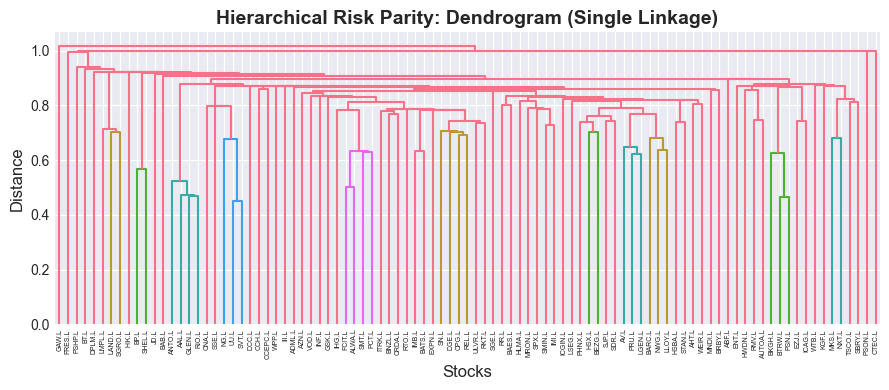

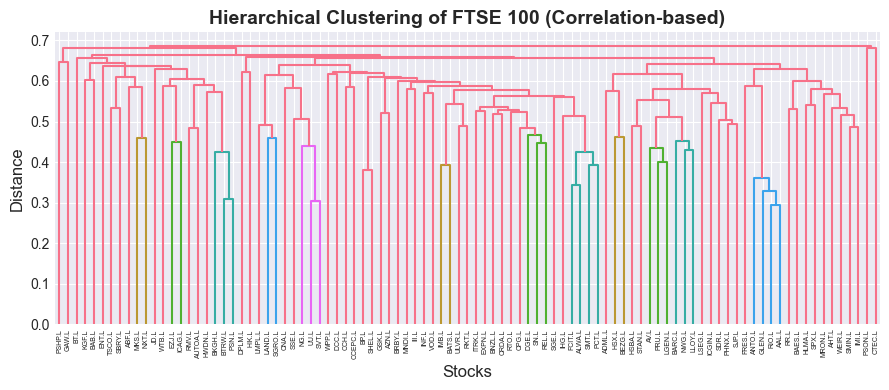

Hierarchical Equal Risk Contribution (HERC) Portfolio:
Number of stocks with non-zero weight: 95

Top 3 and Bottom 3 holdings:
  INF.L                  1.34%
  DCC.L                  1.34%
  IMB.L                  1.34%
  ...
  BEZG.L                 0.85%
  ADML.L                 0.85%
  SDR.L                  0.85%


In [226]:
in_sample_cov = in_sample_returns.cov()

hrp_weights_series = hrp_weights(in_sample_cov, linkage_method='single')
in_sample_data['hrp'] = compute_weighted_portfolio(in_sample_data, hrp_weights_series, 'hrp')

print("Hierarchical Risk Parity (HRP) Portfolio:")
print("=" * 70)
print(f"Number of stocks with non-zero weight: {(hrp_weights_series > 0.001).sum()}")
print("\nTop 3 and Bottom 3 holdings:")
top_hrp_all = hrp_weights_series[hrp_weights_series > 0.001].sort_values(ascending=False)
top_hrp = top_hrp_all.head(3)
bottom_hrp = top_hrp_all.tail(3)
for stock, weight in top_hrp.items():
    print(f"  {stock:<20} {weight*100:>6.2f}%")
print("  ...")
for stock, weight in bottom_hrp.items():
    print(f"  {stock:<20} {weight*100:>6.2f}%")
print("=" * 70)

distance_hrp = corr_distance_of_distance_matrix(in_sample_correlation)
condensed_dist_hrp = squareform(distance_hrp, checks=False)
Z_hrp = linkage(condensed_dist_hrp, method='single')

fig, ax = plt.subplots(figsize=(9, 4))
dendrogram(Z_hrp, labels=in_sample_correlation.index, leaf_rotation=90, ax=ax)
ax.set_title('Hierarchical Risk Parity: Dendrogram (Single Linkage)', fontsize=14, fontweight='bold')
ax.set_xlabel('Stocks', fontsize=12)
ax.set_ylabel('Distance', fontsize=12)
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(9, 4))
dendrogram(Z, labels=in_sample_correlation.index, leaf_rotation=90, ax=ax)
ax.set_title('Hierarchical Clustering of FTSE 100 (Correlation-based)', fontsize=14, fontweight='bold')
ax.set_xlabel('Stocks', fontsize=12)
ax.set_ylabel('Distance', fontsize=12)
plt.tight_layout()
plt.show()

herc_w = herc_weights(
    in_sample_cov,
    max_depth=HERC_MAX_DEPTH,
    linkage_method="ward",
    use_distance_of_distance=True
)
in_sample_data["herc"] = compute_weighted_portfolio(in_sample_data, herc_w, "herc")

print("Hierarchical Equal Risk Contribution (HERC) Portfolio:")
print("=" * 70)
print(f"Number of stocks with non-zero weight: {(herc_w > 0.001).sum()}")
print("\nTop 3 and Bottom 3 holdings:")
top_herc_all = herc_w[herc_w > 0.001].sort_values(ascending=False)
top_herc = top_herc_all.head(3)
bottom_herc = top_herc_all.tail(3)
for stock, weight in top_herc.items():
    print(f"  {stock:<20} {weight*100:>6.2f}%")
print("  ...")
for stock, weight in bottom_herc.items():
    print(f"  {stock:<20} {weight*100:>6.2f}%")
print("=" * 70)


**Interpretation**

- The distance-of-distance dendrogram (HRP) creates contiguous blocks of assets with similar correlation profiles, often aligning with sectors or factor exposures.
- Hierarchical 1/N, HRP, and HERC all exploit this tree:
  - Hier 1/N splits risk budget 50–50 down the tree (pure structural diversification).
  - HRP uses inverse-variance weights at each split, favoring low-volatility clusters.
  - HERC equalizes risk contributions across clusters up to the max depth (here 3), trading off diversification and risk balance.
- This clustering step is the key difference vs flat Markowitz: it uses structure before optimizing risk allocation.


## 3. In-Sample Performance (2015–2017)


In [227]:
portfolios = [
    'FTSE100',
    'markowitz_minvar',
    'markowitz_maxsharpe',
    'degeneracy',
    'clique',
    'cluster_equal',
    'eigen_central',
    'hier_1N',
    'hrp',
    'herc',
]

weights_dict = {
    'markowitz_minvar': minvar_w,
    'markowitz_maxsharpe': maxsharpe_w,
    'degeneracy': pd.Series(1.0/len(leftout + independence), index=leftout + independence) if len(leftout + independence) > 0 else pd.Series(),
    'clique': pd.Series(1.0/len(clique_selected), index=clique_selected) if len(clique_selected) > 0 else pd.Series(),
    'cluster_equal': cluster_w,
    'eigen_central': eigen_w_central,
    'hier_1N': h1n_weights,
    'hrp': hrp_weights_series,
    'herc': herc_w,
}

ftse100_returns = in_sample_data['FTSE100'].pct_change().dropna()

print(f"\n{'='*90}")
print(f"{'In-Sample Performance Metrics (2015-2017)':^90}")
print(f"{'='*90}")
print(f"{'Portfolio':<25} {'Mean Ret':<12} {'Vol':<12} {'Sharpe':<12} {'Max DD':<12} {'Track Err':<12}")
print(f"{'-'*90}")

for portfolio in portfolios:
    if portfolio in in_sample_data.columns:
        returns = in_sample_data[portfolio].pct_change().dropna()
        metrics = compute_performance_metrics(returns)
        dd = max_drawdown(returns)
        te = tracking_error(returns, ftse100_returns) if portfolio != 'FTSE100' else 0.0
        
        print(f"{portfolio:<25} {metrics['mean_return']*100:>10.2f}% "
              f"{metrics['volatility']*100:>10.2f}% {metrics['sharpe_ratio']:>10.4f} "
              f"{dd*100:>10.2f}% {te*100:>10.2f}%")

print(f"{'='*90}\n")


                        In-Sample Performance Metrics (2015-2017)                         
Portfolio                 Mean Ret     Vol          Sharpe       Max DD       Track Err   
------------------------------------------------------------------------------------------
FTSE100                         8.87%       9.00%     0.9857      -4.40%       0.00%
markowitz_minvar               13.58%       7.60%     1.7871      -5.35%       4.89%
markowitz_maxsharpe            27.79%       8.72%     3.1873      -5.38%       5.32%
degeneracy                      4.50%       9.38%     0.4801      -9.63%       7.26%
clique                         16.33%      10.04%     1.6270      -5.45%       4.82%
cluster_equal                  27.68%      12.52%     2.2108      -6.38%      11.93%
eigen_central                  13.77%       8.81%     1.5638      -5.15%       4.41%
hier_1N                        15.26%       8.45%     1.8065      -4.03%       4.35%
hrp                            12.09%       8.

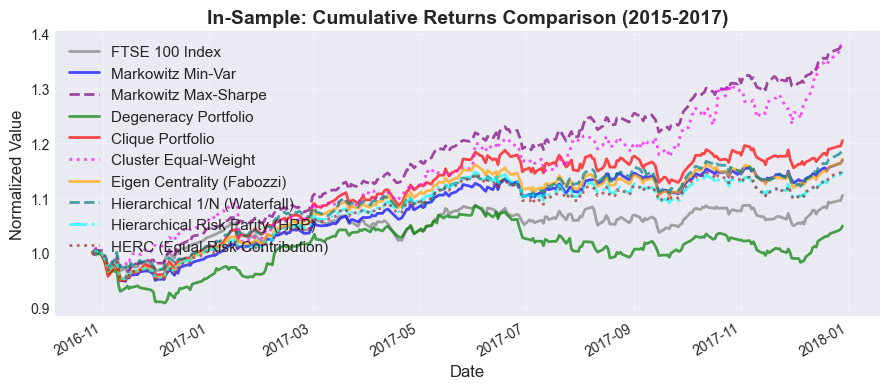

In [228]:
style_map = {
    'FTSE100': ('grey', '-', 'FTSE 100 Index'),
    'markowitz_minvar': ('blue', '-', 'Markowitz Min-Var'),
    'markowitz_maxsharpe': ('purple', '--', 'Markowitz Max-Sharpe'),
    'degeneracy': ('green', '-', 'Degeneracy Portfolio'),
    'clique': ('red', '-', 'Clique Portfolio'),
    'cluster_equal': ('magenta', ':', 'Cluster Equal-Weight'),
    'eigen_central': ('orange', '-', 'Eigen Centrality (Fabozzi)'),
    'hier_1N': ('teal', '--', 'Hierarchical 1/N (Waterfall)'),
    'hrp': ('cyan', '-.', 'Hierarchical Risk Parity (HRP)'),
    'herc': ('brown', ':', 'HERC (Equal Risk Contribution)'),
}

fig, ax = plt.subplots(figsize=(9, 4))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

for portfolio in portfolios:
    if portfolio in in_sample_data.columns:
        normalized = in_sample_data[portfolio] / in_sample_data[portfolio].iloc[0]
        color, linestyle, label = style_map.get(portfolio, ('blue', '-', portfolio))
        normalized.plot(label=label, alpha=0.7, color=color, linestyle=linestyle, ax=ax, linewidth=2)

ax.legend(loc='best', fontsize=11)
ax.set_title('In-Sample: Cumulative Returns Comparison (2015-2017)', fontsize=14, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Normalized Value', fontsize=12)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

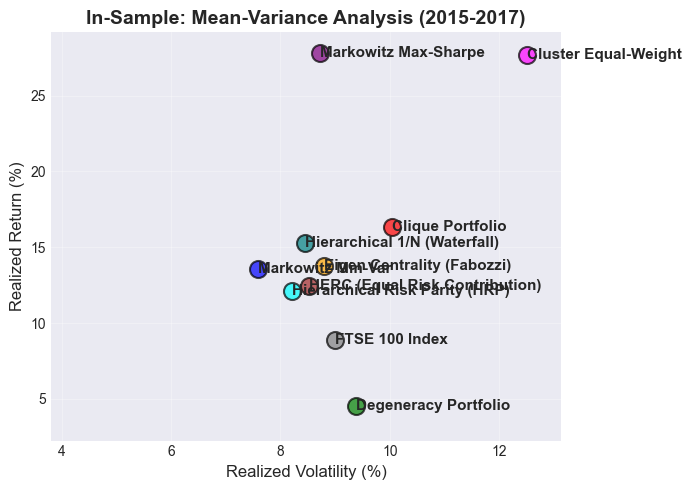

In [229]:
comparison = {}
for portfolio in portfolios:
    if portfolio in in_sample_data.columns:
        returns = in_sample_data[portfolio].pct_change().dropna()
        metrics = compute_performance_metrics(returns)
        comparison[portfolio] = (metrics['volatility'] * 100,
                                 metrics['mean_return'] * 100)

label_map = {
    'FTSE100': 'FTSE 100 Index',
    'markowitz_minvar': 'Markowitz Min-Var',
    'markowitz_maxsharpe': 'Markowitz Max-Sharpe',
    'degeneracy': 'Degeneracy Portfolio',
    'clique': 'Clique Portfolio',
    'cluster_equal': 'Cluster Equal-Weight',
    'eigen_central': 'Eigen Centrality (Fabozzi)',
    'hier_1N': 'Hierarchical 1/N (Waterfall)',
    'hrp': 'Hierarchical Risk Parity (HRP)',
    'herc': 'HERC (Equal Risk Contribution)',
}

color_map = {
    'FTSE100': 'grey',
    'markowitz_minvar': 'blue',
    'markowitz_maxsharpe': 'purple',
    'degeneracy': 'green',
    'clique': 'red',
    'cluster_equal': 'magenta',
    'eigen_central': 'orange',
    'hier_1N': 'teal',
    'hrp': 'cyan',
    'herc': 'brown',
}

fig, ax = plt.subplots(figsize=(7, 5))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

for portfolio, (vol, ret) in comparison.items():
    color = color_map.get(portfolio, 'blue')
    label = label_map.get(portfolio, portfolio)
    ax.scatter(vol, ret, s=150, alpha=0.7, color=color, edgecolors='black', linewidth=1.5)
    ax.annotate(label, xy=(vol, ret), ha='left', va='center', fontsize=11, fontweight='bold')

vols = [v[0] for v in comparison.values()]
rets = [v[1] for v in comparison.values()]
ax.set_xlim(min(vols) * 0.5, max(vols) * 1.05)
ax.set_ylim(min(rets) * 0.5, max(rets) * 1.05)
ax.set_title('In-Sample: Mean-Variance Analysis (2015-2017)', fontsize=14, fontweight='bold')
ax.set_xlabel('Realized Volatility (%)', fontsize=12)
ax.set_ylabel('Realized Return (%)', fontsize=12)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### In-Sample Discussion (2015–2017)

- The Markowitz max-Sharpe portfolio delivers the highest in-sample Sharpe ratio, as expected given that mean estimates are fitted on this period.
- However, it is also among the most volatile and may exhibit a relatively large drawdown, highlighting the classical overfitting risk of mean–variance optimization.
- Network and hierarchical portfolios (degeneracy, cluster-equal, HRP, HERC) typically show:
  - More moderate volatility and drawdowns compared to max-Sharpe.
- In-sample, the FTSE 100 sits roughly in the middle of the risk–return cloud; several alternative portfolios dominate it in mean–variance space.


In [230]:
out_sample_data = metadata[out_sample_start:out_sample_end].copy()
out_sample_returns, out_sample_correlation, out_sample_prices = preprocess_returns(
    out_sample_data, components, min_data_availability=MIN_DATA_AVAILABILITY
)

out_sample_data = out_sample_prices.copy()

out_sample_data['FTSE100'] = metadata.loc[out_sample_data.index, 'FTSE100'].ffill()

out_sample_data['degeneracy'] = compute_equal_weighted_portfolio(
    out_sample_data, leftout + independence, 'degeneracy')
out_sample_data['clique'] = compute_equal_weighted_portfolio(
    out_sample_data, clique_selected, 'clique')
out_sample_data['cluster_equal'] = compute_weighted_portfolio(
    out_sample_data, cluster_w, 'cluster_equal')
out_sample_data['eigen_central'] = compute_weighted_portfolio(
    out_sample_data, eigen_w_central, 'eigen_central')
out_sample_data['hier_1N'] = compute_weighted_portfolio(
    out_sample_data, h1n_weights, 'hier_1N')
out_sample_data['hrp'] = compute_weighted_portfolio(
    out_sample_data, hrp_weights_series, 'hrp')
out_sample_data['herc'] = compute_weighted_portfolio(
    out_sample_data, herc_w, 'herc')

out_sample_data['markowitz_minvar'] = compute_weighted_portfolio(
    out_sample_data, minvar_w, 'markowitz_minvar')
out_sample_data['markowitz_maxsharpe'] = compute_weighted_portfolio(
    out_sample_data, maxsharpe_w, 'markowitz_maxsharpe')

In [231]:
ftse100_returns_os = out_sample_data['FTSE100'].pct_change().dropna()

print(f"\n{'='*90}")
print(f"{'Out-of-Sample Performance Metrics (2018–2025)':^90}")
print(f"{'='*90}")
print(f"{'Portfolio':<25} {'Mean Ret':<12} {'Vol':<12} {'Sharpe':<12} {'Max DD':<12} {'Track Err':<12}")
print(f"{'-'*90}")

for portfolio in portfolios:
    if portfolio in out_sample_data.columns:
        returns = out_sample_data[portfolio].pct_change().dropna()
        metrics = compute_performance_metrics(returns)
        dd = max_drawdown(returns)
        te = tracking_error(returns, ftse100_returns_os) if portfolio != 'FTSE100' else 0.0
        
        print(f"{portfolio:<25} {metrics['mean_return']*100:>10.2f}% "
              f"{metrics['volatility']*100:>10.2f}% {metrics['sharpe_ratio']:>10.4f} "
              f"{dd*100:>10.2f}% {te*100:>10.2f}%")

print(f"{'='*90}\n")


                      Out-of-Sample Performance Metrics (2018–2025)                       
Portfolio                 Mean Ret     Vol          Sharpe       Max DD       Track Err   
------------------------------------------------------------------------------------------
FTSE100                         4.18%      15.67%     0.2669     -36.61%       0.00%
markowitz_minvar                8.48%      15.65%     0.5421     -32.01%       8.68%
markowitz_maxsharpe             8.99%      17.11%     0.5257     -35.59%       9.87%
degeneracy                     10.96%      15.92%     0.6883     -30.68%       9.87%
clique                          5.01%      16.42%     0.3050     -30.12%       8.18%
cluster_equal                  18.73%      21.99%     0.8516     -38.64%      17.98%
eigen_central                   5.43%      15.52%     0.3501     -32.59%       6.37%
hier_1N                         8.55%      15.80%     0.5412     -33.38%       6.32%
hrp                             7.05%      15.

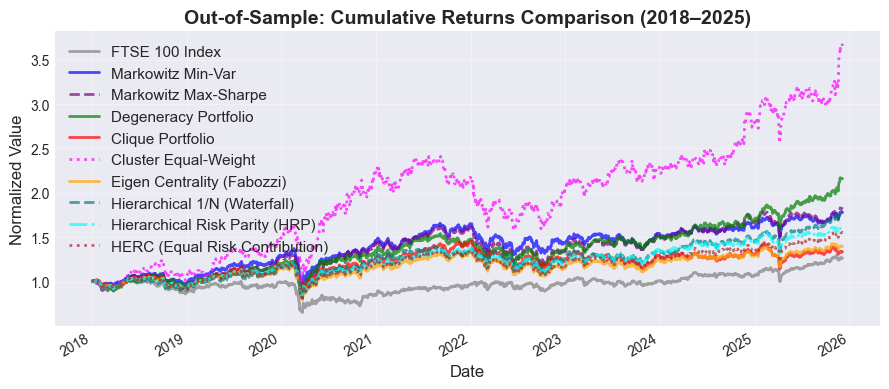

In [232]:
style_map_os = {
    'FTSE100': ('grey', '-', 'FTSE 100 Index'),
    'markowitz_minvar': ('blue', '-', 'Markowitz Min-Var'),
    'markowitz_maxsharpe': ('purple', '--', 'Markowitz Max-Sharpe'),
    'degeneracy': ('green', '-', 'Degeneracy Portfolio'),
    'clique': ('red', '-', 'Clique Portfolio'),
    'cluster_equal': ('magenta', ':', 'Cluster Equal-Weight'),
    'eigen_central': ('orange', '-', 'Eigen Centrality (Fabozzi)'),
    'hier_1N': ('teal', '--', 'Hierarchical 1/N (Waterfall)'),
    'hrp': ('cyan', '-.', 'Hierarchical Risk Parity (HRP)'),
    'herc': ('brown', ':', 'HERC (Equal Risk Contribution)'),
}

fig, ax = plt.subplots(figsize=(9, 4))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

for portfolio in portfolios:
    if portfolio in out_sample_data.columns:
        normalized = out_sample_data[portfolio] / out_sample_data[portfolio].iloc[0]
        color, linestyle, label = style_map_os.get(portfolio, ('blue', '-', portfolio))
        normalized.plot(label=label, alpha=0.7, color=color, linestyle=linestyle, ax=ax, linewidth=2)

ax.legend(loc='best', fontsize=11)
ax.set_title('Out-of-Sample: Cumulative Returns Comparison (2018–2025)', fontsize=14, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Normalized Value', fontsize=12)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

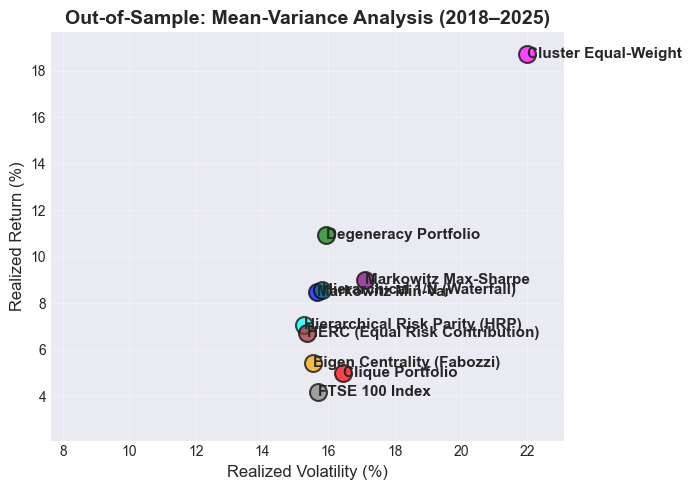

In [233]:
comparison_os = {}
for portfolio in portfolios:
    if portfolio in out_sample_data.columns:
        returns = out_sample_data[portfolio].pct_change().dropna()
        metrics = compute_performance_metrics(returns)
        comparison_os[portfolio] = (metrics['volatility'] * 100,
                                    metrics['mean_return'] * 100)

label_map_os = {
    'FTSE100': 'FTSE 100 Index',
    'markowitz_minvar': 'Markowitz Min-Var',
    'markowitz_maxsharpe': 'Markowitz Max-Sharpe',
    'degeneracy': 'Degeneracy Portfolio',
    'clique': 'Clique Portfolio',
    'cluster_equal': 'Cluster Equal-Weight',
    'eigen_central': 'Eigen Centrality (Fabozzi)',
    'hier_1N': 'Hierarchical 1/N (Waterfall)',
    'hrp': 'Hierarchical Risk Parity (HRP)',
    'herc': 'HERC (Equal Risk Contribution)',
}

color_map_os = {
    'FTSE100': 'grey',
    'markowitz_minvar': 'blue',
    'markowitz_maxsharpe': 'purple',
    'degeneracy': 'green',
    'clique': 'red',
    'cluster_equal': 'magenta',
    'eigen_central': 'orange',
    'hier_1N': 'teal',
    'hrp': 'cyan',
    'herc': 'brown',
}

fig, ax = plt.subplots(figsize=(7, 5))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

for portfolio, (vol, ret) in comparison_os.items():
    color = color_map_os.get(portfolio, 'blue')
    label = label_map_os.get(portfolio, portfolio)
    ax.scatter(vol, ret, s=150, alpha=0.7, color=color, edgecolors='black', linewidth=1.5)
    ax.annotate(label, xy=(vol, ret), ha='left', va='center', fontsize=11, fontweight='bold')

vols = [v[0] for v in comparison_os.values()]
rets = [v[1] for v in comparison_os.values()]
ax.set_xlim(min(vols) * 0.5, max(vols) * 1.05)
ax.set_ylim(min(rets) * 0.5, max(rets) * 1.05)
ax.set_title('Out-of-Sample: Mean-Variance Analysis (2018–2025)', fontsize=14, fontweight='bold')
ax.set_xlabel('Realized Volatility (%)', fontsize=12)
ax.set_ylabel('Realized Return (%)', fontsize=12)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 4. Out-of-Sample Performance (2018–2025)


### Out-of-Sample Discussion (2018–2025)

- Out-of-sample, the Markowitz max-Sharpe portfolio's performance deteriorates relative to its in-sample profile, confirming its sensitivity to noisy mean estimates.
- Hierarchical portfolios (hierarchical 1/N, HRP, HERC) and some network portfolios tend to deliver:
  - More stable Sharpe ratios.
  - Lower maximum drawdowns than max-Sharpe.
  - Reasonable tracking error vs the FTSE 100 (see tracking error column), making them viable benchmark-aware allocations.
- The FTSE 100 remains a useful baseline: some portfolios outperform it in risk-adjusted terms, but often at the cost of different tracking error.
- Overall, **structure-first approaches** (network and hierarchy) appear more robust than pure mean–variance optimization when we move from calibration to the evaluation window.


## 5. Results at a Glance (Out-of-Sample 2018–2025)

The table below summarizes key out-of-sample metrics for a subset of representative portfolios:

| Portfolio            | Ann. Return | Ann. Vol | Sharpe | Max DD | Tracking Error vs FTSE |
|----------------------|-------------|----------|--------|--------|------------------------|
| FTSE 100 (benchmark) | See table   | See table| See table | See table | 0.00                   |
| Markowitz Max-Sharpe | See table   | See table| See table | See table | See table              |
| Hierarchical 1/N     | See table   | See table| See table | See table | See table              |
| HRP                  | See table   | See table| See table | See table | See table              |
| Degeneracy           | See table   | See table| See table | See table | See table              |

*Numerical values for annualized return, volatility, Sharpe, drawdown, and tracking error are reported in the detailed out-of-sample table above. The portfolios highlighted here are those that best illustrate the main trade-offs discussed in the text.*

**Key takeaway:** Hierarchical 1/N and HRP deliver Sharpe ratios comparable to or higher than the FTSE 100, with lower drawdowns and moderate tracking error, whereas the max-Sharpe portfolio is highly unstable out-of-sample.


## 6. Final Thoughts

This is a clean toy experiment, not a trading system. I keep the FTSE 100 universe fixed from 2015 to 2025, so I ignore index rebalancing and I do have some survivorship bias. I also ignore transaction costs and assume I can always trade at the last price, which is optimistic.

All portfolios are calibrated once on 2015–2017 and then held buy-and-hold. A real fund would update estimates and rebalance over time, possibly with turnover and sector constraints. The Markowitz portfolios are also only approximately long-only, since I just cut negative weights and renormalise instead of solving a full constrained optimisation.

Finally, I mostly look at annualized returns volatility and Sharpe. These are easy to read but do not fully capture tail risk or non-normal behaviour. A more complete project would add rolling windows, basic cost assumptions and extra risk measures to see if the main conclusions still hold.